In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import interpret.glassbox
import lightgbm as lgb
import shap
import random
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
from modules.utils import *
nltk.download('stopwords')
stopwords = stopwords.words('english')



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lucas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [42]:
N_SAMPLE = 50000
MAX_FEATURES = 10000
N_TWEET_PRINT = 10

In [43]:
col_names = ['sentiment', 'id', 'date', 'query', 'user', 'text']
df_train = pd.read_csv("../data/Sentiment140-train.csv", encoding="latin-1", header = None, names = col_names)
df_test = pd.read_csv("../data/Sentiment140-test.csv", encoding="latin-1", header = None, names = col_names)
df_dublin = pd.read_csv("../data/citypulse.dublin_city_council.test.csv", encoding="latin-1" )

In [44]:
df_train = df_train.sample(N_SAMPLE).reset_index(drop=True)

In [45]:
df_train['split'] = "train"
df_test['split'] = "test"

In [46]:
df_train['sentiment'] = df_train['sentiment'].apply(convert_sentiment)
df_test['sentiment'] = df_test['sentiment'].apply(convert_sentiment)
df_all = pd.concat([df_train, df_test])

In [47]:
df_dublin['sentiment'] = df_dublin['sentiment'].apply(convert_sentiment_dublin)

In [48]:
df_all['sentiment'].value_counts()

 0    25192
 1    25167
-1      139
Name: sentiment, dtype: int64

In [49]:
df_all = df_all[df_all['sentiment'] != -1]

In [50]:
df_train['sentiment'].value_counts()

0    25015
1    24985
Name: sentiment, dtype: int64

In [51]:
df_test['sentiment'].value_counts()

 1    182
 0    177
-1    139
Name: sentiment, dtype: int64

In [52]:
df_dublin['sentiment'].value_counts()

 1    1000
 0    1000
-1    1000
Name: sentiment, dtype: int64

In [53]:
# df_all['clean_text'] = df_all['text'].apply(lambda x: x.lower())
# df_dublin['clean_text'] = df_dublin['text'].apply(lambda x: x.lower())

In [54]:
df_dublin['text_clean'] = df_dublin['text'].str.lower().apply(lambda x: [item for item in x.split() if item not in stopwords and item.isalpha()])
df_dublin['text_clean'] = df_dublin['text_clean'].apply(lambda x: " ".join(x))

df_train['text_clean'] = df_train['text'].str.lower().apply(lambda x: [item for item in x.split() if item not in stopwords and item.isalpha()])
df_train['text_clean'] = df_train['text_clean'].apply(lambda x: " ".join(x))

df_test['text_clean'] = df_test['text'].str.lower().apply(lambda x: [item for item in x.split() if item not in stopwords and item.isalpha()])
df_test['text_clean'] = df_test['text_clean'].apply(lambda x: " ".join(x))

df_all['text_clean'] = df_all['text'].str.lower().apply(lambda x: [item for item in x.split() if item not in stopwords and item.isalpha()])
df_all['text_clean'] = df_all['text_clean'].apply(lambda x: " ".join(x))

df_dublin['text_clean'] = df_dublin['text'].str.lower().apply(lambda x: [item for item in x.split() if item not in stopwords and item.isalpha()])
df_dublin['text_clean'] = df_dublin['text_clean'].apply(lambda x: " ".join(x))

In [55]:
word_vectorizer = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', sublinear_tf=True, strip_accents='unicode',
                                  stop_words='english', ngram_range=(1, 2), max_features=MAX_FEATURES)
word_vectorizer.fit(df_all['text_clean'])

TfidfVectorizer(max_features=10000, ngram_range=(1, 2), stop_words='english',
                strip_accents='unicode', sublinear_tf=True,
                token_pattern='\\w{1,}')

In [56]:
train_text = df_all.loc[df_all['split']=="train", "text_clean"]
test_text = df_all.loc[df_all['split']=="test", "text_clean"]
all_text = df_all["text_clean"]
y_train = df_all.loc[df_all['split']=="train", "sentiment"]
y_test = df_all.loc[df_all['split']=="test", "sentiment"]
y_all_text = df_all["sentiment"]

In [57]:
x_dublin = df_dublin["text_clean"]
y_dublin = df_dublin["sentiment"]

In [58]:
train_features = word_vectorizer.transform(train_text)
test_features = word_vectorizer.transform(test_text)
all_features = word_vectorizer.transform(all_text)
dublin_features = word_vectorizer.transform(x_dublin)

In [59]:
df_train_features = pd.DataFrame(data = train_features.toarray())
df_train_features.columns = word_vectorizer.get_feature_names()

df_test_features = pd.DataFrame(data = test_features.toarray())
df_test_features.columns = word_vectorizer.get_feature_names()

df_dublin_features = pd.DataFrame(data = dublin_features.toarray())
df_dublin_features.columns = word_vectorizer.get_feature_names()

In [60]:
len(df_test_features)

359

In [61]:
len(y_test)

359

In [62]:
train_lgb = lgb.Dataset(df_train_features, label=y_train)
test_lgb = lgb.Dataset(df_test_features, label=y_test)
dublin_lgb = lgb.Dataset(df_dublin_features, label=y_dublin)

In [63]:
parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.9,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 0
}

model = lgb.train(parameters,
                       train_lgb,
                       valid_sets=test_lgb,
                       num_boost_round=5000,
                       early_stopping_rounds=100)

[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.060331 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[1]	valid_0's auc: 0.623223
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.687248
[3]	valid_0's auc: 0.698951
[4]	valid_0's auc: 0.708558
[5]	valid_0's auc: 0.713649
[6]	valid_0's auc: 0.717064
[7]	valid_0's auc: 0.712982
[8]	valid_0

[265]	valid_0's auc: 0.818697
[266]	valid_0's auc: 0.818914
[267]	valid_0's auc: 0.818371
[268]	valid_0's auc: 0.81834
[269]	valid_0's auc: 0.818216
[270]	valid_0's auc: 0.817874
[271]	valid_0's auc: 0.818464
[272]	valid_0's auc: 0.818557
[273]	valid_0's auc: 0.818712
[274]	valid_0's auc: 0.818805
[275]	valid_0's auc: 0.818712
[276]	valid_0's auc: 0.818837
[277]	valid_0's auc: 0.819551
[278]	valid_0's auc: 0.819706
[279]	valid_0's auc: 0.819721
[280]	valid_0's auc: 0.819752
[281]	valid_0's auc: 0.81969
[282]	valid_0's auc: 0.819721
[283]	valid_0's auc: 0.819783
[284]	valid_0's auc: 0.820233
[285]	valid_0's auc: 0.820233
[286]	valid_0's auc: 0.820264
[287]	valid_0's auc: 0.820885
[288]	valid_0's auc: 0.821072
[289]	valid_0's auc: 0.821072
[290]	valid_0's auc: 0.821103
[291]	valid_0's auc: 0.821072
[292]	valid_0's auc: 0.821134
[293]	valid_0's auc: 0.820668
[294]	valid_0's auc: 0.820544
[295]	valid_0's auc: 0.820544
[296]	valid_0's auc: 0.820823
[297]	valid_0's auc: 0.820823
[298]	valid_

[546]	valid_0's auc: 0.827622
[547]	valid_0's auc: 0.827808
[548]	valid_0's auc: 0.827435
[549]	valid_0's auc: 0.82877
[550]	valid_0's auc: 0.828646
[551]	valid_0's auc: 0.828708
[552]	valid_0's auc: 0.828925
[553]	valid_0's auc: 0.828987
[554]	valid_0's auc: 0.828987
[555]	valid_0's auc: 0.828863
[556]	valid_0's auc: 0.828987
[557]	valid_0's auc: 0.828863
[558]	valid_0's auc: 0.829081
[559]	valid_0's auc: 0.829267
[560]	valid_0's auc: 0.829329
[561]	valid_0's auc: 0.82936
[562]	valid_0's auc: 0.829049
[563]	valid_0's auc: 0.82877
[564]	valid_0's auc: 0.828832
[565]	valid_0's auc: 0.828863
[566]	valid_0's auc: 0.82818
[567]	valid_0's auc: 0.828087
[568]	valid_0's auc: 0.828273
[569]	valid_0's auc: 0.828336
[570]	valid_0's auc: 0.828304
[571]	valid_0's auc: 0.828242
[572]	valid_0's auc: 0.828429
[573]	valid_0's auc: 0.82846
[574]	valid_0's auc: 0.82846
[575]	valid_0's auc: 0.828056
[576]	valid_0's auc: 0.828118
[577]	valid_0's auc: 0.827963
[578]	valid_0's auc: 0.827963
[579]	valid_0's 

In [64]:
predictions = model.predict(all_features)
df_all['sentiment_pred'] = predictions
df_all['sentiment_pred_class'] = df_all['sentiment_pred'].apply(lambda x: round(x))

In [65]:
df_dublin['sentiment_pred'] = model.predict(dublin_features)
df_dublin['sentiment_pred_class'] = df_dublin['sentiment_pred'].apply(lambda x: round(x))

# METRICS
## Research question 1
What are the accuracy/f1/recall/precision of your model on the Sentiment140
dataset? And on the Dublin dataset? (Provide the metrics measurement for each
dataset.)
## Sentiment140 (train-test) and dublin dataset
* Accuracy
* f1
* recall
* precision

## Research question 2
Are they or are they not the same? How large is the difference? Can you think of the
cause? How would you corroborate or refute your hypothesis?
* The model performance is higher in test than train. This may indicate that the test set is not a random selection of tweets from the same dataset as training data. Maybe 
* The model performance with dublin dataset is worse than in train/test. Probably the text in the dublin dataset si somehow different from sentiement140 dataset.
* Some

### TRAIN

In [66]:
y_hat = df_all.loc[df_all['split']=="train", "sentiment"]
y_pred = df_all.loc[df_all['split']=="train", "sentiment_pred_class"]
print(metrics.confusion_matrix(y_hat, y_pred))
print(metrics.classification_report(y_hat, y_pred))
print("Accuracy Score: %.3f" % metrics.accuracy_score(y_hat, y_pred))

[[17266  7749]
 [ 4425 20560]]
              precision    recall  f1-score   support

           0       0.80      0.69      0.74     25015
           1       0.73      0.82      0.77     24985

    accuracy                           0.76     50000
   macro avg       0.76      0.76      0.76     50000
weighted avg       0.76      0.76      0.76     50000

Accuracy Score: 0.757


### TEST

In [67]:
y_hat = df_all.loc[(df_all['split']=="test") & (df_all['sentiment']!=-1), "sentiment"]
y_pred = df_all.loc[(df_all['split']=="test") & (df_all['sentiment']!=-1), "sentiment_pred_class"]
print(metrics.confusion_matrix(y_hat, y_pred))
print(metrics.classification_report(y_hat, y_pred))
print("Accuracy Score: %.3f" % metrics.accuracy_score(y_hat, y_pred))
fpr, tpr, thresholds = metrics.roc_curve(y_hat, y_pred, pos_label=1)
print("AUC: %.3f" % metrics.auc(fpr, tpr))

[[101  76]
 [ 29 153]]
              precision    recall  f1-score   support

           0       0.78      0.57      0.66       177
           1       0.67      0.84      0.74       182

    accuracy                           0.71       359
   macro avg       0.72      0.71      0.70       359
weighted avg       0.72      0.71      0.70       359

Accuracy Score: 0.708
AUC: 0.706


### Dublin dataset

In [68]:
y_hat = df_dublin.loc[(df_dublin['sentiment']!=-1), "sentiment"]
y_pred = df_dublin.loc[(df_dublin['sentiment']!=-1), "sentiment_pred_class"]
print(metrics.confusion_matrix(y_hat, y_pred))
print(metrics.classification_report(y_hat, y_pred))
print("Accuracy Score: %.3f" % metrics.accuracy_score(y_hat, y_pred))

[[537 463]
 [248 752]]
              precision    recall  f1-score   support

           0       0.68      0.54      0.60      1000
           1       0.62      0.75      0.68      1000

    accuracy                           0.64      2000
   macro avg       0.65      0.64      0.64      2000
weighted avg       0.65      0.64      0.64      2000

Accuracy Score: 0.644


### Metrics by category

In [69]:
for category in df_dublin['category'].unique():
    print(category)
    y_hat = df_dublin.loc[(df_dublin['sentiment']!=-1) & (df_dublin['category']!=category), "sentiment"]
    y_pred = df_dublin.loc[(df_dublin['sentiment']!=-1) & (df_dublin['category']!=category), "sentiment_pred_class"]
    print(metrics.confusion_matrix(y_hat, y_pred))
    print(metrics.classification_report(y_hat, y_pred))
    print("Accuracy Score: %.3f" % metrics.accuracy_score(y_hat, y_pred))

Public Spaces
[[530 457]
 [247 745]]
              precision    recall  f1-score   support

           0       0.68      0.54      0.60       987
           1       0.62      0.75      0.68       992

    accuracy                           0.64      1979
   macro avg       0.65      0.64      0.64      1979
weighted avg       0.65      0.64      0.64      1979

Accuracy Score: 0.644
Community and Culture
[[481 377]
 [205 509]]
              precision    recall  f1-score   support

           0       0.70      0.56      0.62       858
           1       0.57      0.71      0.64       714

    accuracy                           0.63      1572
   macro avg       0.64      0.64      0.63      1572
weighted avg       0.64      0.63      0.63      1572

Accuracy Score: 0.630
Mobility
[[399 342]
 [183 632]]
              precision    recall  f1-score   support

           0       0.69      0.54      0.60       741
           1       0.65      0.78      0.71       815

    accuracy            

In [70]:
df_dublin['sentiment_pred_class'] = df_dublin['sentiment_pred'].astype(int)

### Words with Higher TFIDF values in test dataset

In [71]:
feature_array = np.array(word_vectorizer.get_feature_names())
tfidf_sorting = np.argsort(test_features.toarray()).flatten()[::-1]

n = 50
top_n = feature_array[tfidf_sorting][:n]
top_n

array(['reading tweets', 'incredibly', 'tweets', 'reading', 'coming',
       'thing', 'got school', 'got sleep', 'got sims', 'got sick',
       'got shower', 'got seeing', 'got right', 'got sunburn',
       'got really', 'got ready', 'got question', 'got plans',
       'got place', 'got phone', 'got paid', 'got stuck', 'zune hd',
       'got talent', 'got things', 'gotta love', 'gotta early',
       'gotta check', 'gotta', 'gots', 'got work', 'got way', 'got watch',
       'got virus', 'got u', 'got twitter', 'got trouble', 'got ton',
       'got tickets', 'got new', 'got nice', 'got morning', 'gotta wait',
       'got cut', 'got going', 'got free', 'got followers', 'got feeling',
       'got excited', 'got early'], dtype='<U20')

### Words with Higher TFIDF values in dublin dataset

In [72]:
tfidf_sorting = np.argsort(dublin_features.toarray()).flatten()[::-1]
top_n = feature_array[tfidf_sorting][:n]
top_n

array(['north', 'drive', 'years', 'internet', 'kids', 'school', 'zune hd',
       'got really', 'got shower', 'got seeing', 'got school',
       'got right', 'got ready', 'got sims', 'got question', 'got plans',
       'got place', 'got phone', 'got paid', 'got nice', 'got new',
       'got sick', 'got stuck', 'got sleep', 'got virus', 'gotta early',
       'gotta check', 'gotta', 'gots', 'got work', 'got way', 'got watch',
       'got u', 'got miss', 'got twitter', 'got trouble', 'got ton',
       'got tickets', 'got things', 'got talent', 'got sunburn',
       'got morning', 'got lot', 'got love', 'got chance',
       'got followers', 'got feeling', 'got excited', 'got early',
       'got day'], dtype='<U20')

# Wordcloud most frequent words Train vs Test vs Dublin dataset

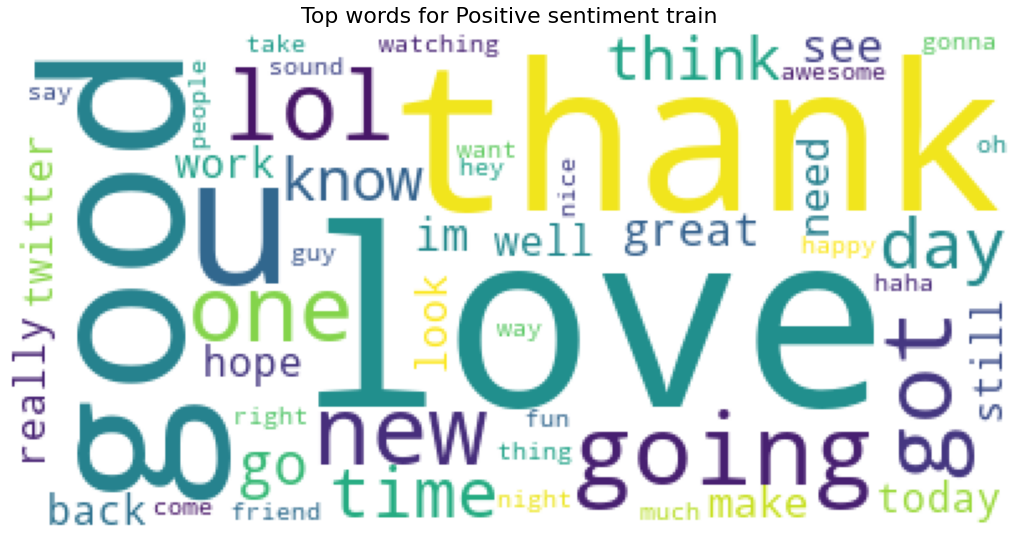

In [73]:
wc = WordCloud(
    background_color='white', 
    max_words=50, 
)
wc.generate(' '.join(text for text in df_train.loc[df_train['sentiment'] == 1, 'text_clean']))
plt.figure(figsize=(18,10))
plt.title('Top words for Positive sentiment train', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

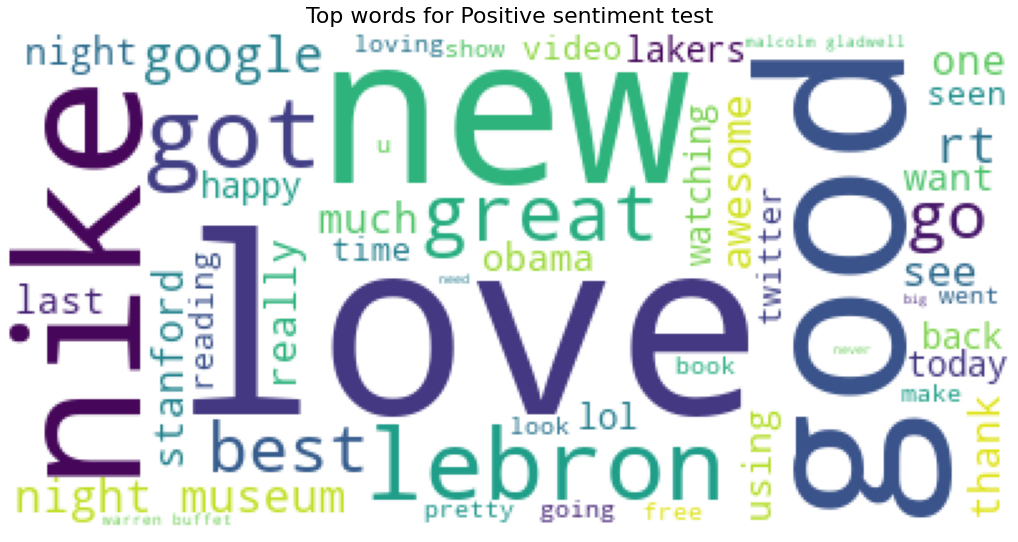

In [74]:
wc = WordCloud(
    background_color='white', 
    max_words=50, 
)
wc.generate(' '.join(text for text in df_test.loc[df_test['sentiment'] == 1, 'text_clean']))
plt.figure(figsize=(18,10))
plt.title('Top words for Positive sentiment test', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

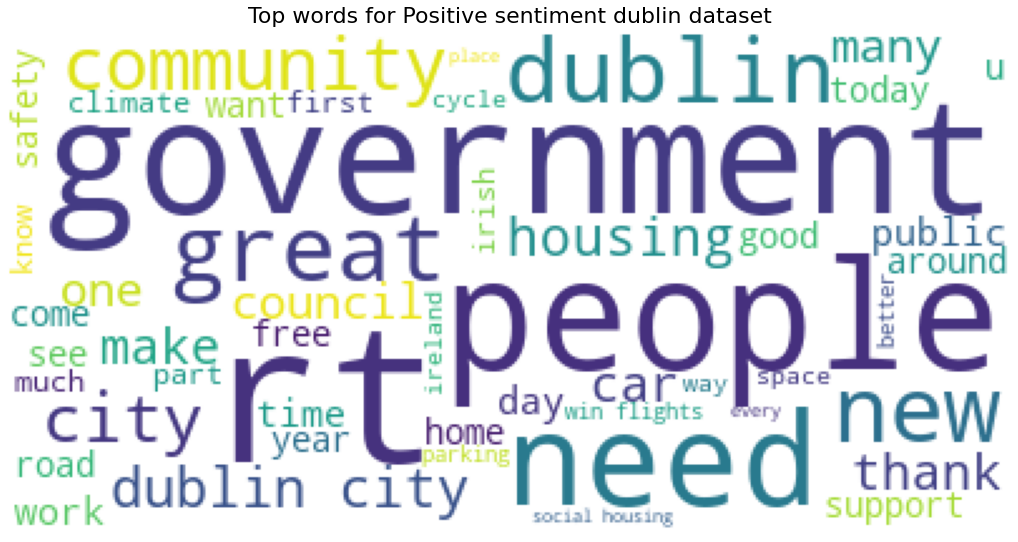

In [75]:
wc = WordCloud(
    background_color='white', 
    max_words=50, 
)
wc.generate(' '.join(text for text in df_dublin.loc[df_dublin['sentiment'] == 1, 'text_clean']))
plt.figure(figsize=(18,10))
plt.title('Top words for Positive sentiment dublin dataset', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

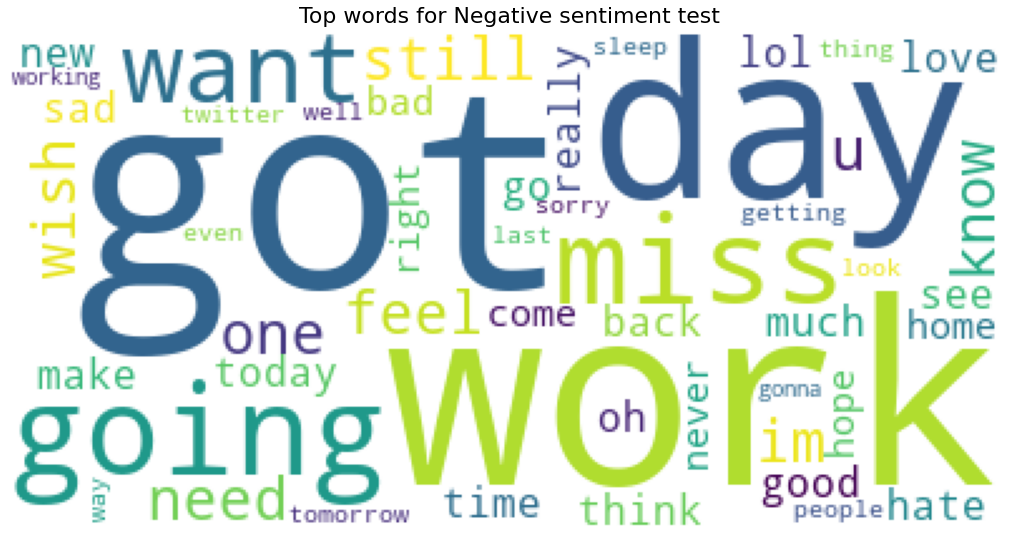

In [76]:
wc = WordCloud(
    background_color='white', 
    max_words=50, 
)
wc.generate(' '.join(text for text in df_train.loc[df_train['sentiment'] == 0, 'text_clean']))
plt.figure(figsize=(18,10))
plt.title('Top words for Negative sentiment test', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

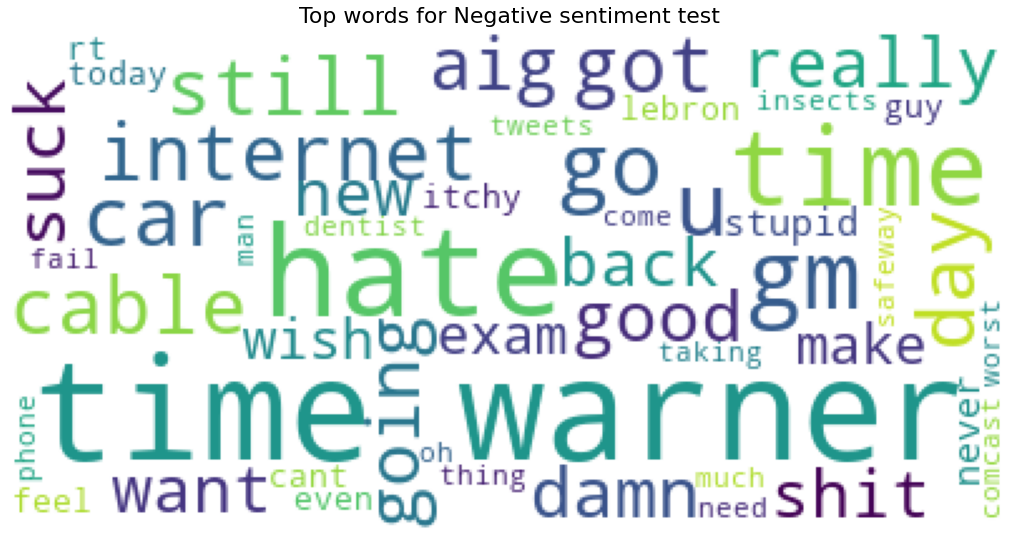

In [77]:
wc = WordCloud(
    background_color='white', 
    max_words=50, 
)
wc.generate(' '.join(text for text in df_test.loc[df_test['sentiment'] == 0, 'text_clean']))
plt.figure(figsize=(18,10))
plt.title('Top words for Negative sentiment test', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

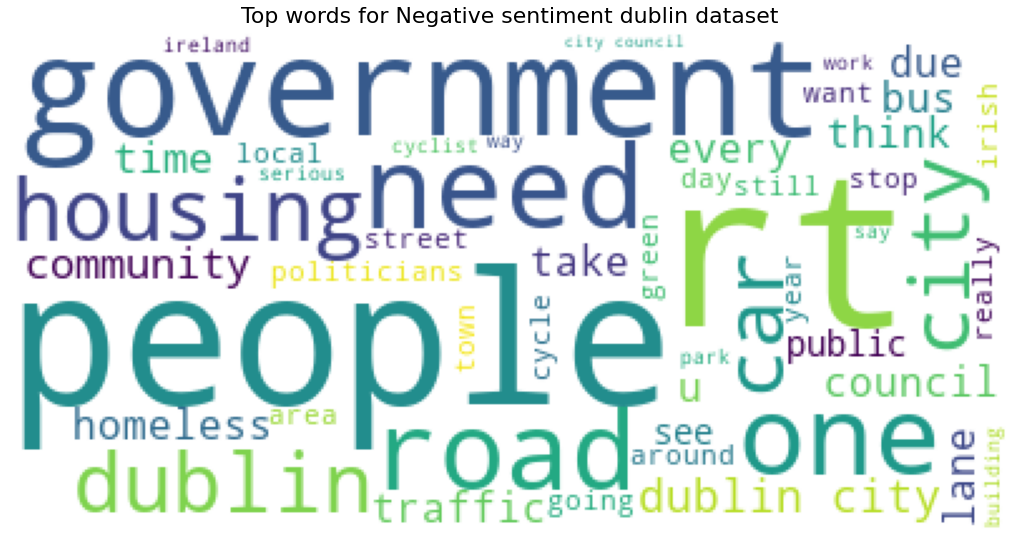

In [78]:
wc = WordCloud(
    background_color='white', 
    max_words=50, 
)
wc.generate(' '.join(text for text in df_dublin.loc[df_dublin['sentiment'] == 0, 'text_clean']))
plt.figure(figsize=(18,10))
plt.title('Top words for Negative sentiment dublin dataset', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

# Baseline model coeficients

In [79]:
data = {'word': word_vectorizer.get_feature_names(), 'coef': lr.coef_[0]}

df_coef = pd.DataFrame(data=data)

NameError: name 'lr' is not defined

In [ ]:
df_coef.sort_values('coef', ascending = False, inplace = True)

### Words with higher coefficients (correlated with positive sentiment prediction)

In [ ]:
df_coef.head(10)

### Words with lower coefficients (correlated with negative sentiment prediction)

In [80]:
df_coef.tail(10)

NameError: name 'df_coef' is not defined

# SHAP values of baseline model with test dataset 

 99%|===================| 357/359 [00:16<00:00]        

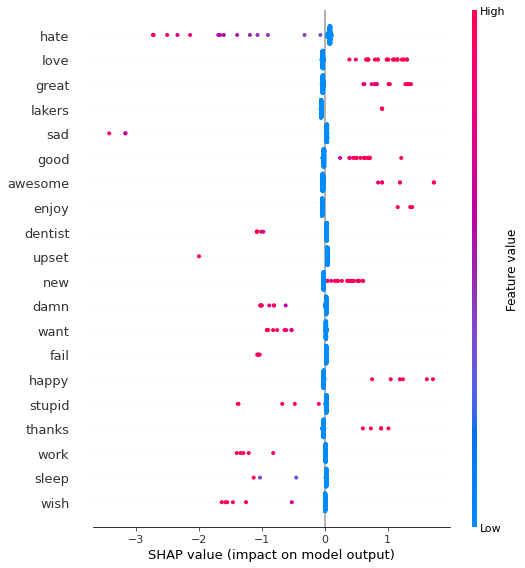

In [84]:
explainer = shap.TreeExplainer(model,
                                 df_test_features)
shap_values = explainer.shap_values(df_test_features)
X_test_array = df_test_features.toarray()
shap.summary_plot(shap_values,
                  X_test_array,
                  feature_names=word_vectorizer.get_feature_names())

# SHAP values of baseline model with dublin dataset 

100%|===================| 2993/3000 [02:17<00:00]        

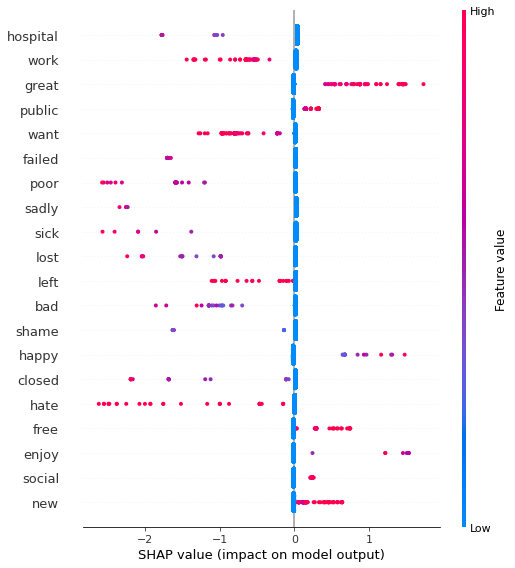

In [86]:
explainer = shap.TreeExplainer(model,
                                 df_dublin_features)
shap_values = explainer.shap_values(df_dublin_features)
X_test_array = dublin_features.toarray()
shap.summary_plot(shap_values,
                  X_test_array,
                  feature_names=word_vectorizer.get_feature_names())

# SHAP values of baseline model with test dataset only with right predictions

 98%|===================| 980/1000 [00:43<00:00]        

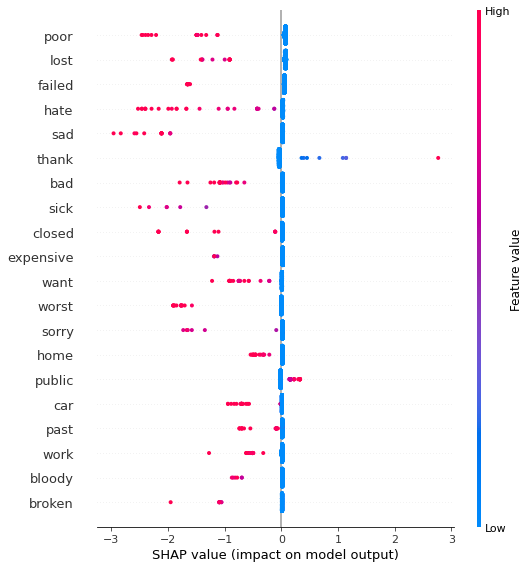

In [88]:
mask = df_dublin[df_dublin['sentiment'] == df_dublin['sentiment_pred_class']].index

explainer = shap.TreeExplainer(model,
                                 df_dublin_features.loc[mask])
shap_values = explainer.shap_values(df_dublin_features.loc[mask])
X_test_array = dublin_features[mask].toarray()
shap.summary_plot(shap_values,
                  X_test_array,
                  feature_names=word_vectorizer.get_feature_names())

# SHAP values of baseline model with test dataset only with wrong predictions

 99%|===================| 1986/2000 [01:26<00:00]        

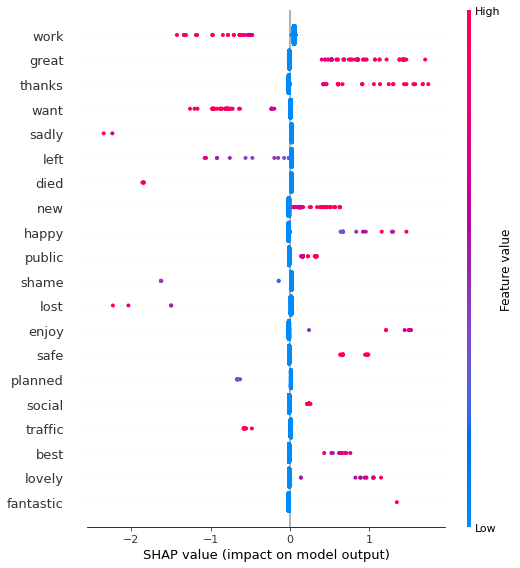

In [89]:
mask = df_dublin[df_dublin['sentiment'] != df_dublin['sentiment_pred_class']].index

explainer = shap.TreeExplainer(model,
                                 df_dublin_features.loc[mask])
shap_values = explainer.shap_values(df_dublin_features.loc[mask])
X_test_array = dublin_features[mask].toarray()
shap.summary_plot(shap_values,
                  X_test_array,
                  feature_names=word_vectorizer.get_feature_names())

# SHAP values for individual cases of wrong predictions

Tweet 1/10
Real sentiment: 1
Predicted sentiment: 0
@DanMulhall @EamonnMallie @MoLI_Museum .@DubCityCouncil #parks dept does great job all year round. Grma - I regularly walk through St Stephenâs Green &amp; am always grateful #Dublin


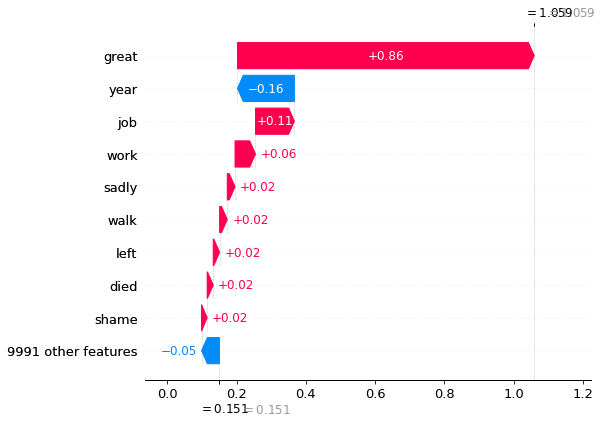

Tweet 2/10
Real sentiment: 1
Predicted sentiment: 0
Love my city and community!! Rallying together for what is right ðð½ðð½ðð½ðð½ @selenatwest @NinaWest 

Supporters rally outside Delaware Drag 101 class https://t.co/sCNRDZ9cvp


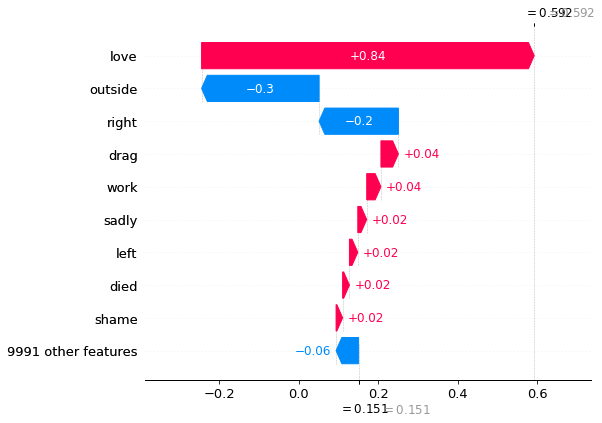

Tweet 3/10
Real sentiment: 1
Predicted sentiment: 0
Bringing shared #micromobility e-bike &amp; e-scooter solutions to bear on Dublinâs traffic congestion, will help our ranking enormously

Looking forward to @Dub_Bleeper @MobyMove new schemes + arrival of shared scooter operators in time also @smartdublin @jcudden @LordMayorDublin https://t.co/Adw9XsJOTQ


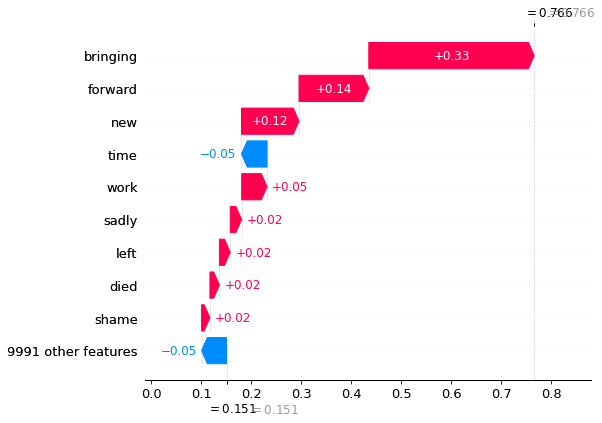

Tweet 4/10
Real sentiment: 1
Predicted sentiment: 0
@rothairisbeoir @__kbaker__ @cullen_ellen @willdesigndub @dublincycling @DubCityCouncil Aw man. And there I was, for just a moment, so happy.


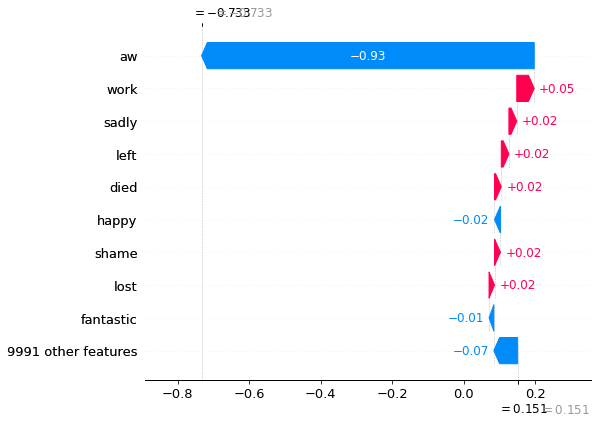

Tweet 5/10
Real sentiment: 1
Predicted sentiment: 0
@OConnorOisin @TUDublinEPS @IrishPedestrian @LorraineFitzsim @UCDRUP @DublinCommuters High Street  .. 6 lane urban motorway through Medieval city


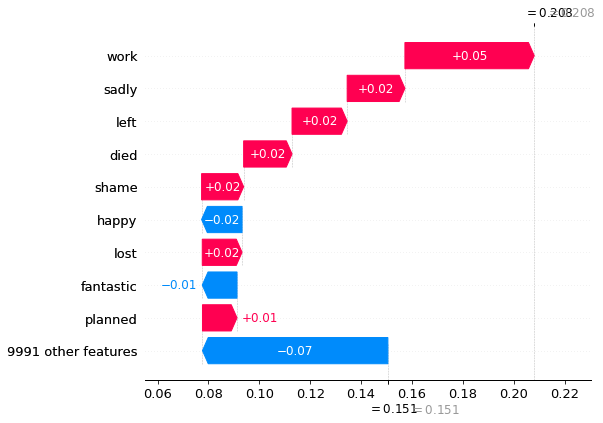

Tweet 6/10
Real sentiment: 1
Predicted sentiment: 0
RT @ChildRightsIRL: In 1919, The Democratic Programme of the First DÃ¡il promised âIt shall be the first duty of the Government of the Repubâ¦


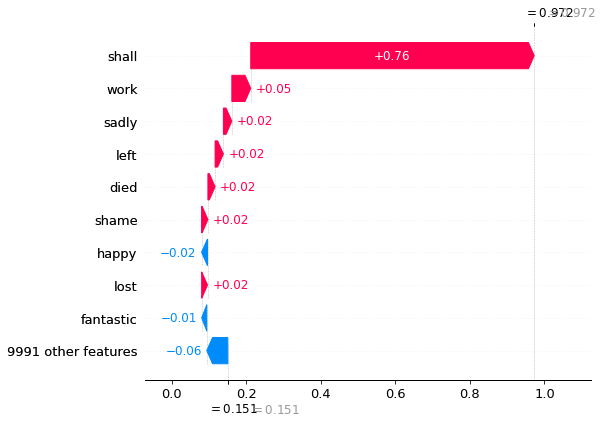

Tweet 7/10
Real sentiment: 1
Predicted sentiment: 0
Evo Morales is still the legal president of Bolivia as his resignation was not legally accepted by an elected government. The UN must act now,


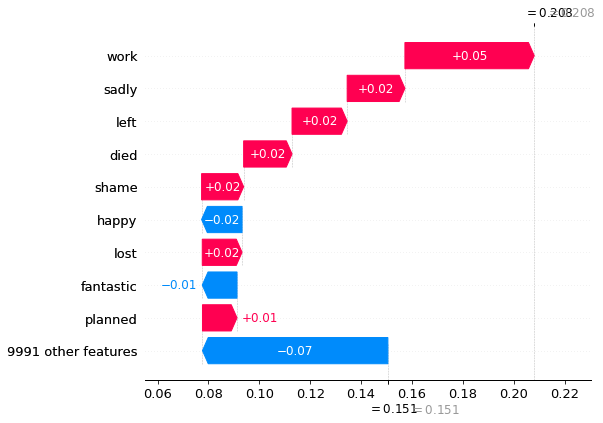

Tweet 8/10
Real sentiment: 1
Predicted sentiment: 0
@ShayBrennan @dlrcc @DublinVelo2019 @DublinCommuters @dlrcycling @IBIKEDublin @Cyclistie @dlbcycles @Greenaer We might be able to help with the clothing issueð


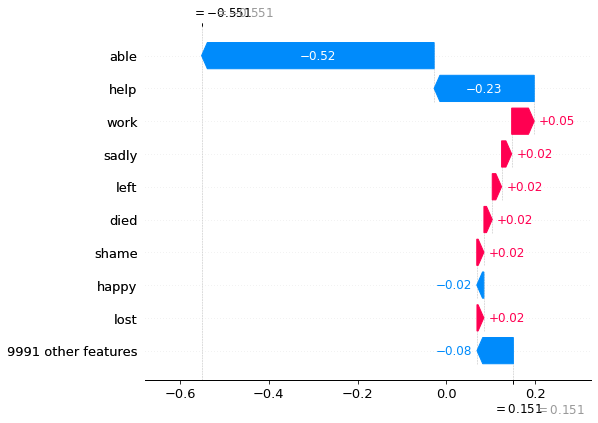

Tweet 9/10
Real sentiment: 1
Predicted sentiment: 0
@DubCham Finally. Good on you Dublin Chamber - this will solve the long standing white water rafting crisis that has gripped our beloved capital.


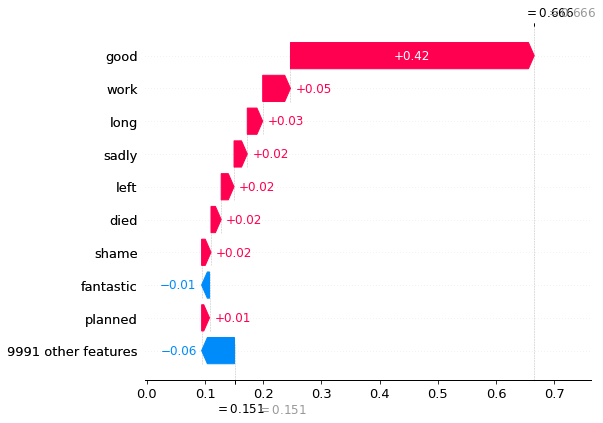

Tweet 10/10
Real sentiment: 1
Predicted sentiment: 0
@Ciara87C Dublin city council must have seen that mumsnet review saying thereâs nothing to do in Dublin and decided to take immediate action.  Keeping the tourists happy should be the top priority.


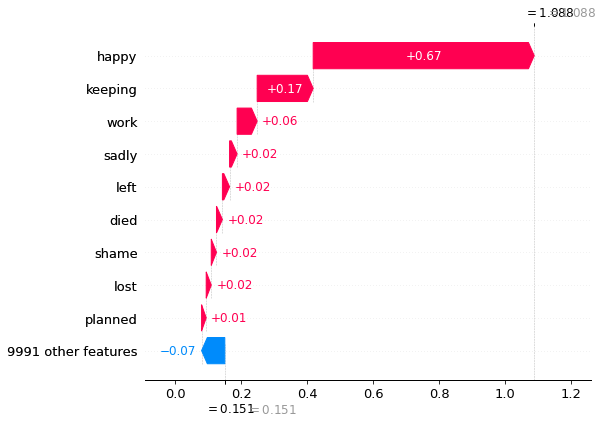

In [90]:
for i in range(N_TWEET_PRINT):
    y_true_n = df_dublin[df_dublin['sentiment'] != df_dublin['sentiment_pred_class']].loc[mask[i], 'sentiment']
    y_pred_n = df_dublin[df_dublin['sentiment'] != df_dublin['sentiment_pred_class']].loc[mask[i], 'sentiment_pred_class']
    print(f"Tweet {i+1}/{N_TWEET_PRINT}")
    print(f"Real sentiment: {y_true_n}")
    print(f"Predicted sentiment: {y_pred_n}")
    print(df_dublin[df_dublin['sentiment'] != df_dublin['sentiment_pred_class']].loc[mask[i], 'text'])
    shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values[i], feature_names=word_vectorizer.get_feature_names())